**Import necessary packages**

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
%cd 

/ceph/hpc/home/novljanj


**Nucleotide distribution around polyA signal in up, down and control genes.**

In [2]:
# Import the transcripts
dataset = pd.read_table(r'/ceph/hpc/home/novljanj/data_storage/projects/LIN28A_associated/results/Trying_CNNs/QuantseqGroups_with_fa.bed', header=None, names= ['chromosome', 'start', 'end', 'classification', 'log2fold', 'strand', 'gene_name', 'sequence'])
dataset

,chromosome,start,end,classification,log2fold,strand,gene_name,sequence
0,chr10,24648303,24649802,DOWN,-6.899042,-,ENSMUSG00000019989,TGAATGAATGGATGTATAAAGCCATTTGACAAAATGGGGACATTTC...
1,chr4,99546268,99546859,DOWN,-5.904965,+,ENSMUSG00000067261,TAGTGATGAGCTAGTGGCCGGGCCGGACGGCGGCCTCTGGCAGCAG...
2,chrX,85239198,85239553,DOWN,-5.527307,+,ENSMUSG00000025056,TGAAGGCATATGTCCACTCAAGTGCATTTTACTATAGATGGAGAAA...
3,chr15,85760430,85760774,DOWN,-4.238394,+,ENSMUSG00000022385,TGAGCAGCGCACAGCCCTCTGCTGTTGATTCTGTTTCCTTCTGATG...
4,chr13,114588825,114590341,DOWN,-4.188287,-,ENSMUSG00000021765,GAATCTGCCTGTAAAACCTGAGCCATTGATTCTTCAGAACTTTCTG...
...,...,...,...,...,...,...,...,...
4871,chr2,152454543,152454649,UP,6.869512,+,ENSMUSG00000044863,TAACTGCCCAGAAGCCTGAAGCCCAGATAATACAGATGGCAAAGCT...
4872,chr15,85419637,85421592,UP,7.345146,-,ENSMUSG00000022382,TGAGGCTCCCGCGCAGGCGCGCTCGGCCCCTGCCGACCCTGCGGCC...
4873,chr8,95739612,95740845,UP,8.463418,+,ENSMUSG00000031785,TAAGCCACCGCCACACCTCCCCTCCGGGAGGACACATGCATGGCGT...
4874,chr18,67500590,67500855,UP,8.887039,+,ENSMUSG00000024526,TAACCAGGGCACAGCTACAGAGGCCCAGGGACCCTGCTCTCTGTTA...


For DOWN:
Number of excluded sequences: 310
Number of kept sequences: 873
For ['CONTROL', 'UP']:
Number of excluded sequences: 1154
Number of kept sequences: 2539


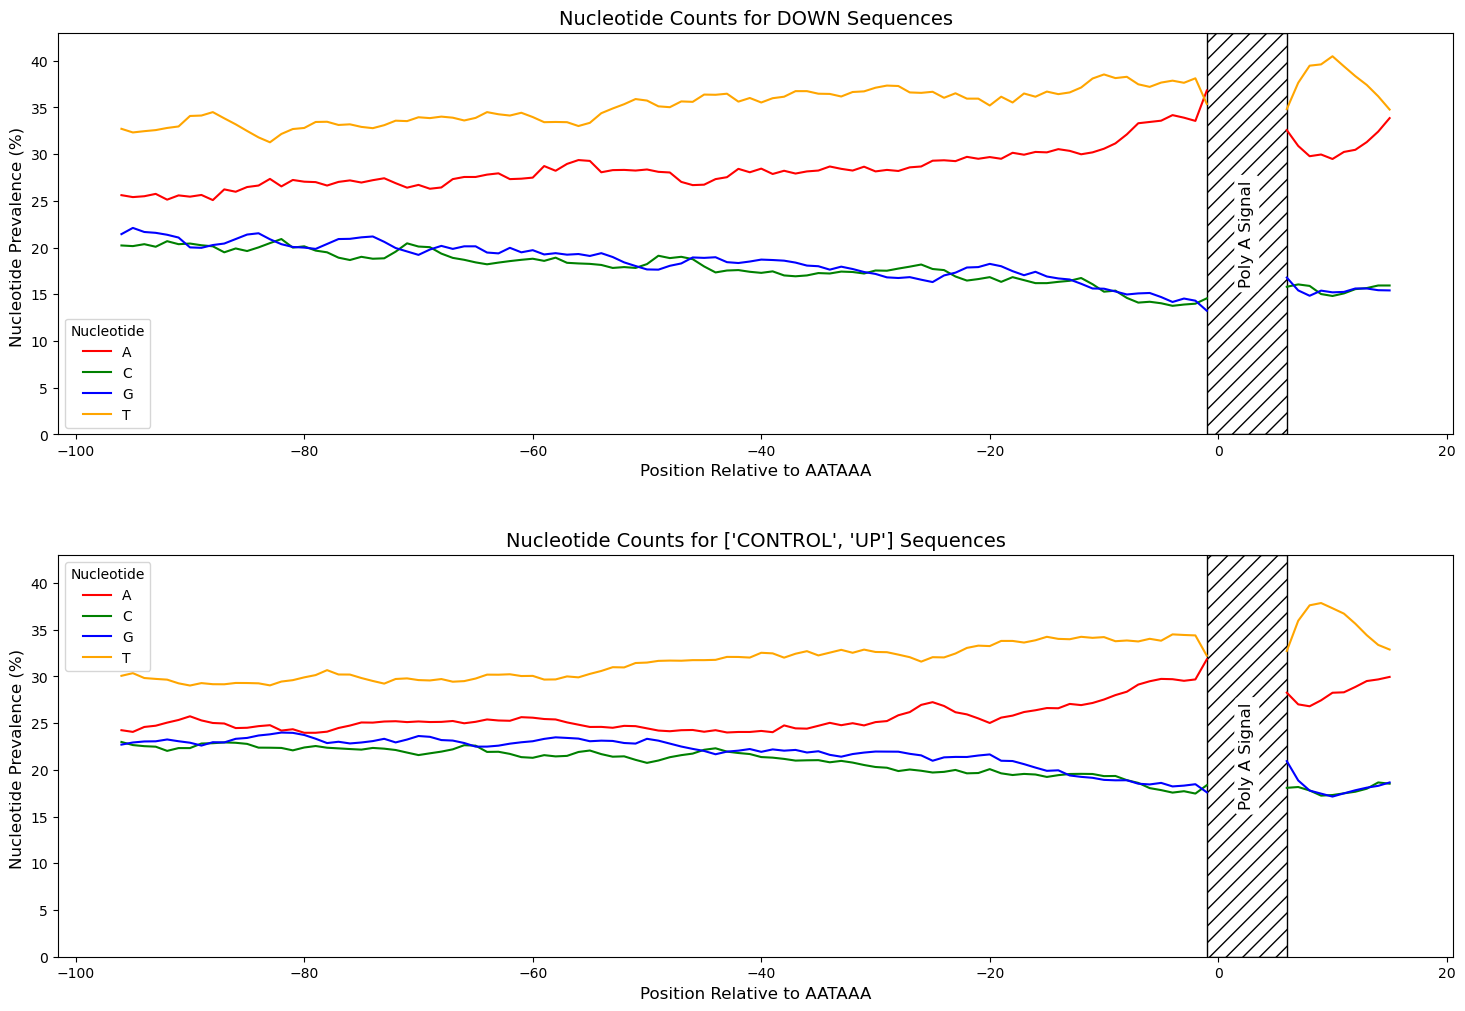

In [3]:
# Define the range for importance scores calculation
upstream = 100
downstream = 20

# Define the range for drawing the polyA signal
polyA_start = -1
polyA_end = 6

# Define the list of nucleotides and their corresponding colors for the plot
nucleotides = ['A','C','G','T']
colors = ['red', 'green', 'blue', 'orange']

# Categories
categories = ["DOWN", ["CONTROL", "UP"]]

# Create a figure with three subplots
fig, axs = plt.subplots(len(categories), figsize=(18, 6*len(categories)))

for cat_index, category in enumerate(categories):
    # Create an empty DataFrame to hold the data
    df = pd.DataFrame(index=range(-upstream, downstream), columns=nucleotides).fillna(0)

    number_excluded = 0
    number_kept = 0
    # Loop over each sequence
    if category == "DOWN":
        for sequence in dataset[dataset["classification"]==category]["sequence"]:
            # Find the terminal AATAAA
            index = sequence.rfind('AATAAA')

            # Check if 'AATAAA' is not found or it's too close to the ends of the window
            if index == -1 or index < upstream or index > len(sequence) - downstream:
                number_excluded += 1
                continue  # Skip this sequence
            number_kept += 1
            # Count the occurrences of each nucleotide in the window
            for i in range(index - upstream, index + downstream):
                position = i - index
                nucleotide = sequence[i]
                if nucleotide in nucleotides:
                    df.loc[position, nucleotide] += 1
    else:
        for sequence in dataset[dataset["classification"] != "DOWN"]["sequence"]:
            # Find the terminal AATAAA
            index = sequence.rfind('AATAAA')

            # Check if 'AATAAA' is not found or it's too close to the ends of the window
            if index == -1 or index < upstream or index > len(sequence) - downstream:
                number_excluded += 1
                continue  # Skip this sequence
            number_kept += 1
            # Count the occurrences of each nucleotide in the window
            for i in range(index - upstream, index + downstream):
                position = i - index
                nucleotide = sequence[i]
                if nucleotide in nucleotides:
                    df.loc[position, nucleotide] += 1

    print(f"For {category}:")
    print(f"Number of excluded sequences: {number_excluded}")
    print(f"Number of kept sequences: {number_kept}")
    
    # Normalize the nucleotide counts
    df = (df / number_kept)*100

    # Create two subsets of the DataFrame to not draw the polyA signal
    subset1 = df[df.index <= polyA_start]
    subset2 = df[df.index >= polyA_end].iloc[::-1]

    # After counting the nucleotide occurrences, apply the moving average smoothing
    subset1_smoothed = subset1.rolling(window=5).mean()
    subset2_smoothed = subset2.rolling(window=5).mean().iloc[::-1]

    # Prepare DataFrame for seaborn
    subset1_melt = subset1_smoothed.reset_index().melt(id_vars='index', var_name='Nucleotide', value_name='Score')
    subset2_melt = subset2_smoothed.reset_index().melt(id_vars='index', var_name='Nucleotide', value_name='Score')
    
    # Create a line plot
    sns.lineplot(x='index', y='Score', hue='Nucleotide', data=subset1_melt, palette=colors, ax=axs[cat_index])
    sns.lineplot(x='index', y='Score', hue='Nucleotide', data=subset2_melt, palette=colors, legend=False, ax=axs[cat_index])

    # Set the maximum value for the y-axis
    
    axs[cat_index].set_ylim(0, 43)

    # Draw a vertical bar with black and white criss-cross pattern
    bar_height = axs[cat_index].get_ylim()[1] - axs[cat_index].get_ylim()[0]  # Calculate the height of the bar based on y-axis limits

    bar = patches.Rectangle((polyA_start, axs[cat_index].get_ylim()[0]), polyA_end - polyA_start, bar_height, hatch='//', facecolor='none', edgecolor='black')
    axs[cat_index].add_patch(bar)

    # Add "Poly A Site" label to the bar vertically
    text_x_pos = (polyA_start + polyA_end) / 2  # Calculate the midpoint of the bar for x-coordinate
    text_y_pos = axs[cat_index].get_ylim()[0] + (bar_height / 2)  # Calculate the midpoint of the bar for y-coordinate

    text_box_props = dict(boxstyle='round', facecolor='white', edgecolor='none')
    axs[cat_index].text(text_x_pos, text_y_pos, 'Poly A Signal', ha='center', va='center', rotation='vertical', fontsize=12, bbox=text_box_props)
    
    # Add title to the plot
    axs[cat_index].set_title(f"Nucleotide Counts for {category} Sequences", fontsize=14)

    # Add the x-axis and y-axis labels
    axs[cat_index].set_xlabel('Position Relative to AATAAA', fontsize=12)
    axs[cat_index].set_ylabel('Nucleotide Prevalence (%) ', fontsize=12)

plt.subplots_adjust(hspace=0.3)  # adjust the vertical spacing
# export picture as svg
#plt.savefig('nucleotide_counts_for_down_sequences.svg', bbox_inches='tight')

# Display the plot
plt.show()